# EDA: iris

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from sklearn.datasets import load_iris
from sklearn.decomposition import FastICA
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from helpers.base_imports import *

## Create new EDA

In [3]:
eda = EDA(name="iris")
eda

Loading 'edas.csv'
Loading 'iris' eda


EDA: iris
Columns: Index(['description', 'n features', 'n samples', 'f/n ratio', 'noise', 'stats',
       'class balance', 'outliers', 'skewness', 'correlations', 'DR potential',
       'dataset.1', 'dataset.2'],
      dtype='object')
Datasets: Index(['iris'], dtype='object', name='dataset')

## Get raw dataset from remote source

In [4]:
# fetch dataset
data = load_iris(as_frame=True)
data.frame.head(5)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [5]:
list(data.target_names)

['setosa', 'versicolor', 'virginica']

In [6]:
disp_df(data.frame)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
5,5.4,3.9,1.7,0.4,0
6,4.6,3.4,1.4,0.3,0
7,5.0,3.4,1.5,0.2,0
8,4.4,2.9,1.4,0.2,0
9,4.9,3.1,1.5,0.1,0


In [7]:
X = data.frame.drop(columns="target")
y = data.frame.target
X.shape, y.shape

((150, 4), (150,))

In [8]:
eda.update_param("description", "Species (3 classes) from sepals/petals dimensions")
eda.update_param("n features", X.shape[1])
eda.update_param("n samples", X.shape[0])
eda.update_param("f/n ratio", X.shape[1] / X.shape[0])

Fairly low F/N, so should be fine. (~50 samples per unique feature)

F/N interpretation:

Low F/N (e.g., <0.01):
- Typically, sufficient data is available for training.
- Emphasis can be placed on optimizing model complexity or exploring more advanced models.


Moderate F/N (e.g., ~0.1–1):
- The dataset has a balanced number of features and samples.
- Careful attention is needed to avoid overfitting with complex models.


High F/N (e.g., >1):
- There are more features than samples, making the dataset sparse.
- Dimensionality reduction (e.g., PCA, feature selection) or simpler models may be necessary to avoid overfitting.

In [9]:
eda.summary_df

,description,n features,n samples,f/n ratio,noise,stats,class balance,outliers,skewness,correlations,DR potential,dataset.1,dataset.2
dataset,,,,,,,,,,,,,
iris,Species (3 classes) from sepals/petals dimensions,4,150,0.026667,"None, no missing vals",petal l/w have highest variation,Balanced,sepal width has a 4 outliers,"petal l/w slight left skew, sepal l/w slight r...","several strong (>.8) correlations, some linear...","PCA: 2 components to explain 95% variance, ICA...",iris,NaN


## Noise

In [10]:
eda.update_param("noise", "None, no missing vals")

## Stats

In [11]:
skewness = X.skew()
summary_stats = X.describe().T
summary_stats["skewness"] = skewness
summary_stats[["min", "max", "mean", "std", "skewness", "25%", "50%", "75%"]]

,min,max,mean,std,skewness,25%,50%,75%
sepal length (cm),4.3,7.9,5.843333,0.828066,0.314911,5.1,5.80,6.4
sepal width (cm),2.0,4.4,3.057333,0.435866,0.318966,2.8,3.00,3.3
petal length (cm),1.0,6.9,3.758000,1.765298,-0.274884,1.6,4.35,5.1
petal width (cm),0.1,2.5,1.199333,0.762238,-0.102967,0.3,1.30,1.8


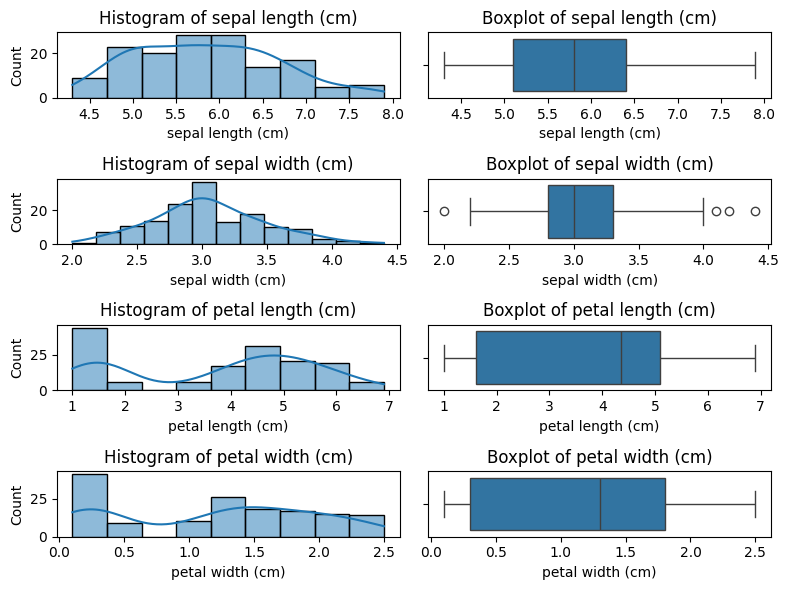

In [12]:
fig, ax = plot_feature_statistics(X, X.columns, line=False)
fig.savefig(f"{FIGS_DIR}/{eda.name}_feature-statistics.png")

In [13]:
eda.update_param("skewness", "petal l/w slight left skew, sepal l/w slight right skew")
eda.update_param("stats", "petal l/w have highest variation ")
eda.update_param("outliers", "sepal width has a 4 outliers")

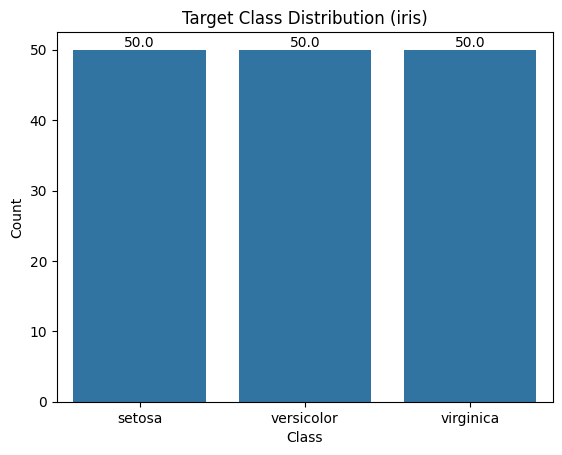

In [14]:
# class distribution of whole dataset
ax = sns.countplot(x=data.target_names[y])
plt.title(f"Target Class Distribution ({eda.name})")
plt.xlabel("Class")
plt.ylabel("Count")

# Annotate each bar with the count
for p in ax.patches:
    height = p.get_height()
    ax.annotate(
        f"{height}",
        (p.get_x() + p.get_width() / 2.0, height),
        ha="center",
        va="center",
        xytext=(0, 5),
        textcoords="offset points",
    )

plt.savefig(f"{FIGS_DIR}/{eda.name}_target-class-distribution.png")
plt.show()

In [15]:
eda.update_param("class balance", "Balanced")

## Feature Correlations

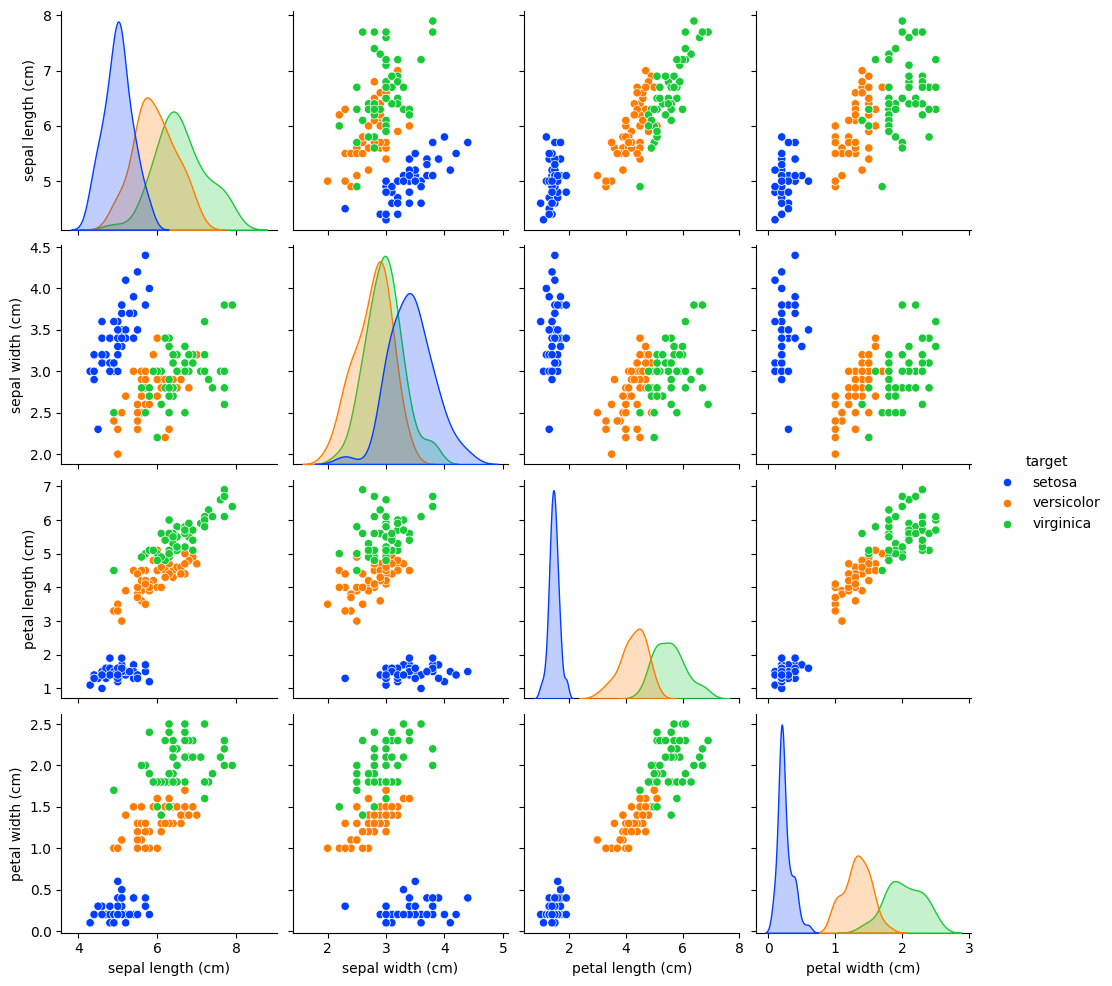

In [16]:
df = data.frame.copy()
df["target"] = data.target_names[y]
# df.head(5)
sns.pairplot(data=df, hue="target", palette="bright")
plt.savefig(f"{FIGS_DIR}/{eda.name}_pairplot.png")

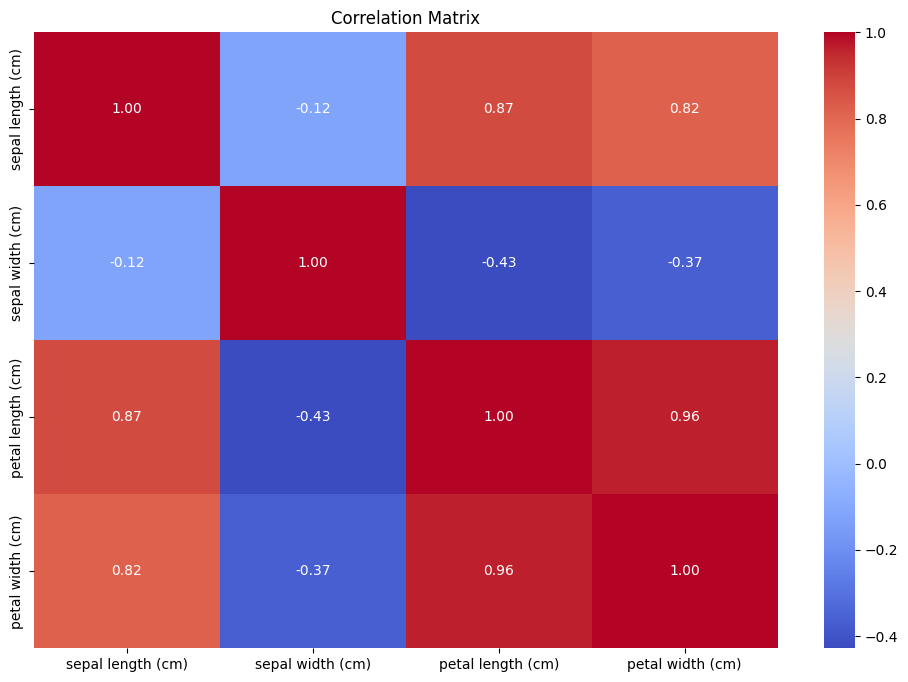

In [17]:
# Create a heatmap of the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(X.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")

plt.savefig(f"{FIGS_DIR}/{eda.name}_correlation-matrix.png")
plt.show()

In [18]:
eda.update_param(
    "correlations", "several strong (>.8) correlations, some linear some poly"
)

## Dimensionality Reduction Potential

In [19]:
# PCA - number of components to explain 95% variance
pca_pipe = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("pca", PCA()),
    ]
)
pca_pipe.fit(X)

Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA())])

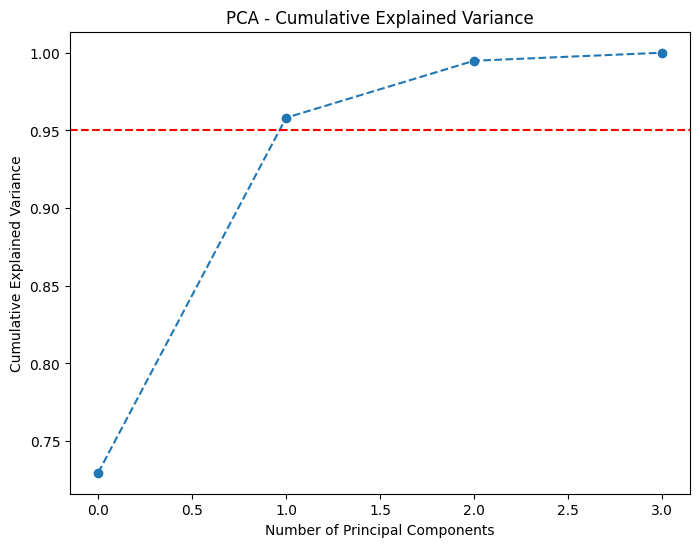

Number of components to explain 95% of the variance: 2


In [20]:
explained_variance_ratio = pca_pipe.named_steps["pca"].explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

plt.figure(figsize=(8, 6))
plt.plot(cumulative_explained_variance, marker="o", linestyle="--")
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA - Cumulative Explained Variance")
plt.axhline(y=0.95, color="r", linestyle="--")  # Threshold for 95% explained variance
plt.show()

# Number of components to explain 95% variance
num_components_95 = np.argmax(cumulative_explained_variance >= 0.95) + 1
print(f"Number of components to explain 95% of the variance: {num_components_95}")

In [21]:
# ICA - number of independent components
ica_pipe = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("ica", FastICA()),
    ]
)
components = ica_pipe.fit_transform(X)

# Number of independent components
num_independent_components = components.shape[1]
print(f"Number of independent components found: {num_independent_components}")

Number of independent components found: 4


In [22]:
eda.update_param(
    "DR potential",
    "PCA: 2 components to explain 95% variance, ICA: 4 independent components",
)

## Save EDA results

In [23]:
eda.summary_df

,description,n features,n samples,f/n ratio,noise,stats,class balance,outliers,skewness,correlations,DR potential,dataset.1,dataset.2
dataset,,,,,,,,,,,,,
iris,Species (3 classes) from sepals/petals dimensions,4,150,0.026667,"None, no missing vals",petal l/w have highest variation,Balanced,sepal width has a 4 outliers,"petal l/w slight left skew, sepal l/w slight r...","several strong (>.8) correlations, some linear...","PCA: 2 components to explain 95% variance, ICA...",iris,NaN


In [24]:
eda.save(overwrite_existing=True)

Loading 'edas.csv'
Overwriting existing iris
Saving iris to results/edas.csv


---

# Create and save a shuffled 80/20 train/test split

In [28]:
dataset_name0 = "iris-20test-shuffled-v0"
X_train0, X_test0, y_train0, y_test0 = train_test_split(
    X,
    y,
    test_size=0.20,  # 20% of data for testing
    shuffle=True,  # shuffle data before splitting
    random_state=0,
)
X_train0.shape, X_test0.shape

((120, 4), (30, 4))

Make sure train and test target distributions roughly match the original dataset.

In [29]:
data.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

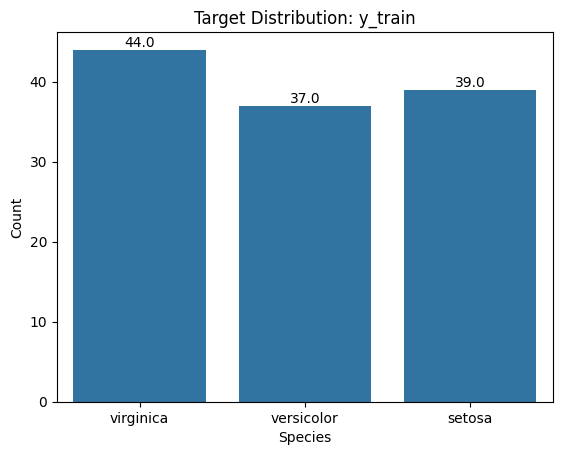

In [30]:
# class distribution: training target dists still balanced?
ax = sns.countplot(x=data.target_names[y_train0])
plt.title("Target Distribution: y_train")
plt.xlabel("Species")
plt.ylabel("Count")

# Annotate each bar with the count
for p in ax.patches:
    height = p.get_height()
    ax.annotate(
        f"{height}",
        (p.get_x() + p.get_width() / 2.0, height),
        ha="center",
        va="center",
        xytext=(0, 5),
        textcoords="offset points",
    )

plt.savefig(f"{FIGS_DIR}/{dataset_name0}_target-class-distribution-y_train.png")
plt.show()

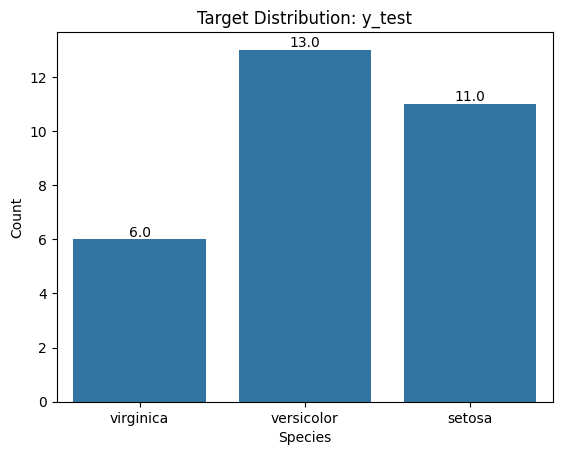

In [31]:
# class distribution: training target dists still balanced?
ax = sns.countplot(x=data.target_names[y_test0])
plt.title("Target Distribution: y_test")
plt.xlabel("Species")
plt.ylabel("Count")

# Annotate each bar with the count
for p in ax.patches:
    height = p.get_height()
    ax.annotate(
        f"{height}",
        (p.get_x() + p.get_width() / 2.0, height),
        ha="center",
        va="center",
        xytext=(0, 5),
        textcoords="offset points",
    )

plt.savefig(f"{FIGS_DIR}/{dataset_name0}_target-class-distribution-y_test.png")
plt.show()

Make sure the feature statistics are similar to the original dataset.

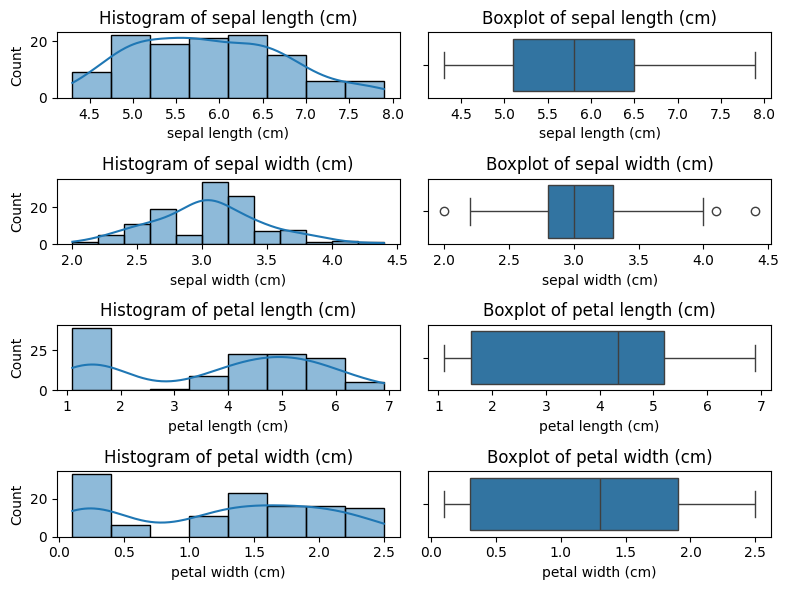

In [32]:
fig, ax = plot_feature_statistics(
    dataframe=X_train0, feature_names=X_train0.columns, line=False
)
fig.savefig(f"{FIGS_DIR}/{dataset_name0}_feature-statistics-X_train.png")

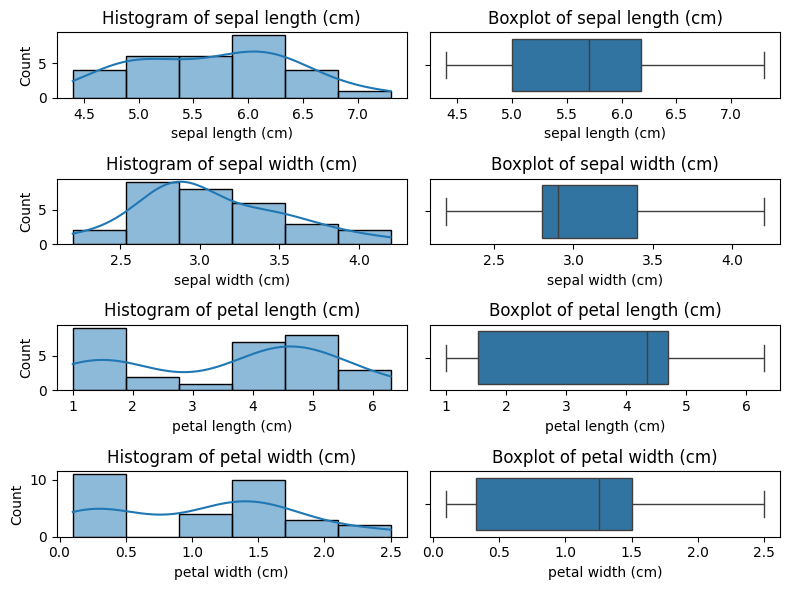

In [33]:
fig, ax = plot_feature_statistics(
    dataframe=X_test0, feature_names=X_test0.columns, line=False
)
fig.savefig(f"{FIGS_DIR}/{dataset_name0}_feature-statistics-X_test.png")

Okay, looks good enough. Lets save it.

In [ ]:
save_dataset(
    dataset_name=dataset_name0,
    X_train=X_train0,
    X_test=X_test0,
    y_train=y_train0,
    y_test=y_test0,
    target_names=pd.DataFrame(data.target_names, columns=["target_names"]),
)

# Create and save another just like it but shuffled differently

In [31]:
dataset_name1 = "iris-20test-shuffled-v1"
X_train1, X_test1, y_train1, y_test1 = train_test_split(
    X,
    y,
    test_size=0.20,  # 20% of data for testing
    shuffle=True,  # shuffle data before splitting
    random_state=1,
)
X_train1.shape, X_test1.shape

((120, 4), (30, 4))

Make sure train and test target distributions roughly match the original dataset.

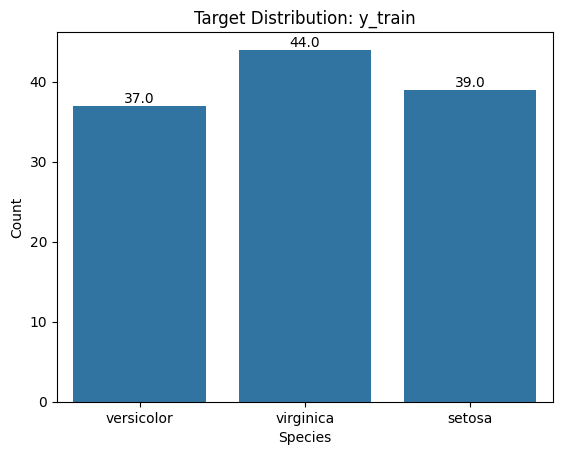

In [32]:
# class distribution: training target dists still balanced?
ax = sns.countplot(x=data.target_names[y_train1])
plt.title("Target Distribution: y_train")
plt.xlabel("Species")
plt.ylabel("Count")

# Annotate each bar with the count
for p in ax.patches:
    height = p.get_height()
    ax.annotate(
        f"{height}",
        (p.get_x() + p.get_width() / 2.0, height),
        ha="center",
        va="center",
        xytext=(0, 5),
        textcoords="offset points",
    )

plt.savefig(f"{FIGS_DIR}/{dataset_name1}_target-class-distribution-y_train.png")
plt.show()

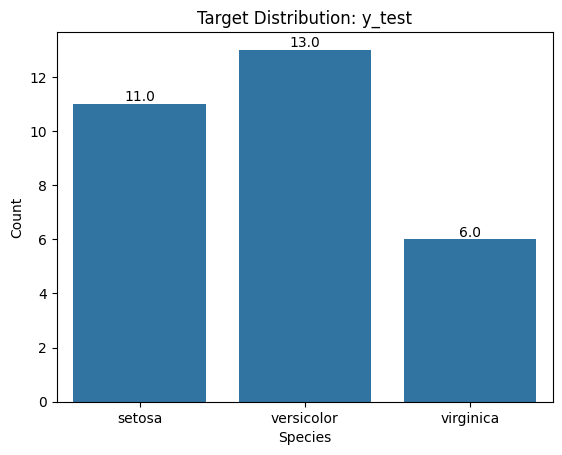

In [33]:
# class distribution: training target dists still balanced?
ax = sns.countplot(x=data.target_names[y_test1])
plt.title("Target Distribution: y_test")
plt.xlabel("Species")
plt.ylabel("Count")

# Annotate each bar with the count
for p in ax.patches:
    height = p.get_height()
    ax.annotate(
        f"{height}",
        (p.get_x() + p.get_width() / 2.0, height),
        ha="center",
        va="center",
        xytext=(0, 5),
        textcoords="offset points",
    )

plt.savefig(f"{FIGS_DIR}/{dataset_name1}_target-class-distribution-y_test.png")
plt.show()

Make sure the feature statistics are similar to the original dataset.

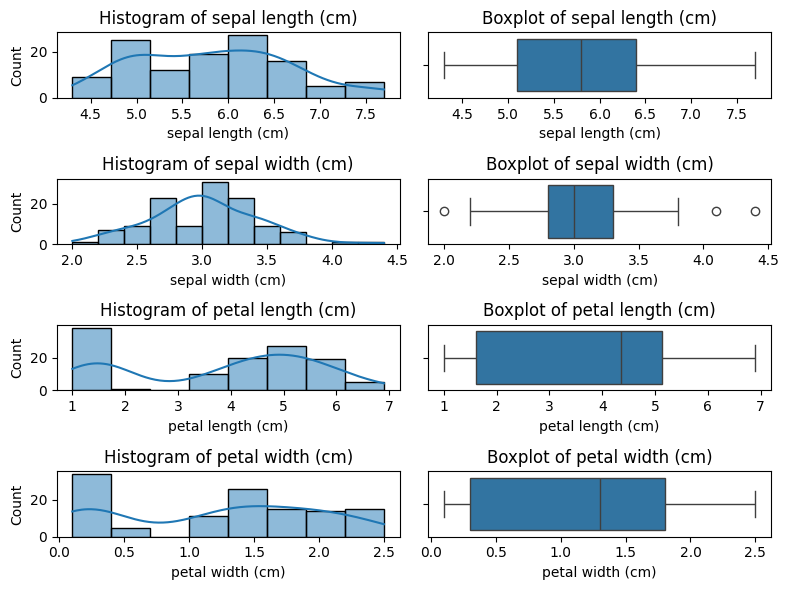

In [34]:
fig, ax = plot_feature_statistics(
    dataframe=X_train1, feature_names=X_train1.columns, line=False
)
fig.savefig(f"{FIGS_DIR}/{dataset_name1}_feature-statistics-X_train.png")

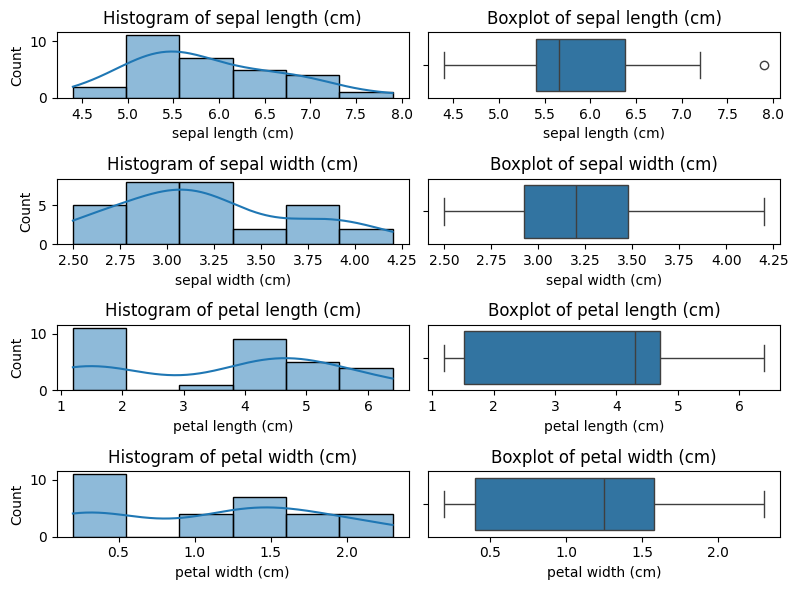

In [35]:
fig, ax = plot_feature_statistics(
    dataframe=X_test1, feature_names=X_test1.columns, line=False
)
fig.savefig(f"{FIGS_DIR}/{dataset_name1}_feature-statistics-X_test.png")

Okay, looks good enough. Lets save it.

In [36]:
save_dataset(
    dataset_name=dataset_name1
    X_train=X_train1,
    X_test=X_test1,
    y_train=y_train1,
    y_test=y_test1,
    target_names=pd.DataFrame(data.target_names, columns=["target_names"]),
)